# Dataset

In [20]:
import numpy as np
from matplotlib import pyplot as plt
import cv2

In [5]:
# Configuration variables
TOY_DATASET_URL = "https://storage.googleapis.com/fchouteau-isae-deep-learning/toy_aircraft_dataset_2023.npz"

In [6]:
ds = np.lib.npyio.DataSource(destpath="/tmp/")
f = ds.open(TOY_DATASET_URL, "rb")

toy_dataset = np.load(f)
trainval_images : np.ndarray = toy_dataset["train_images"]
trainval_labels : np.ndarray = toy_dataset["train_labels"]
test_images : np.ndarray = toy_dataset["test_images"]
test_labels : np.ndarray = toy_dataset["test_labels"]

In [7]:
# 2688 image dans le train, Image de taille 64 x 64, 3 channel (RGB)
print(trainval_images.shape)

# Moitié de aircraft donc autre moitié de background
print(trainval_labels.sum())

(2688, 64, 64, 3)
1344


In [8]:
test_images.shape

(896, 64, 64, 3)

# Model dans keras

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models
import torch

2025-02-07 18:20:35.925751: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738948835.951361    9678 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738948835.958791    9678 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-07 18:20:35.985254: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:


keras_model = models.Sequential([
    # layers.InputLayer(shape=(64,64,3)),
    layers.Conv2D(16, kernel_size=3, activation='relu', input_shape=(64, 64, 3)), # 
    layers.Conv2D(16, kernel_size=3, activation='relu'),
    layers.MaxPooling2D(pool_size=2),

    layers.Conv2D(32, kernel_size=3, activation='relu'),
    layers.Conv2D(32, kernel_size=3, activation='relu'),
    layers.Conv2D(32, kernel_size=3, activation='relu'),
    layers.MaxPooling2D(pool_size=2),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(1, activation='sigmoid'),
])

keras_model.summary()

_ = keras_model.predict(test_images[:1])
_ = keras_model(test_images[:1])

/home/bolympio/miniconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_50 (Conv2D)              │ (None, 62, 62, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 60, 60, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 28, 28, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 26, 26, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │       294,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 320,945 (1.22 MB)

 Trainable params: 320,945 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


In [112]:
keras_model.load_weights("./aircraft.weights.h5")
keras_model.compile(optimizer='adam',
                  loss='binary_crossentropy',  # Use 'categorical_crossentropy' for multi-class
                  metrics=['accuracy'])

In [113]:
history = keras_model.fit(trainval_images, trainval_labels, epochs=1, batch_size=32, validation_split=0.2)

68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 0.9889 - loss: 0.0601 - val_accuracy: 0.9480 - val_loss: 0.4788


In [114]:
test_loss, test_acc = keras_model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc}")

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9257 - loss: 0.6125
Test accuracy: 0.9196428656578064


In [95]:
from xplique.attributions import GradCAM, Lime

In [115]:
LABEL_NAMES = ["Not an aircraft", "Aircraft"]

print("Labels counts :")
for l, c, label in zip(*np.unique(test_labels, return_counts=True), LABEL_NAMES):
    print(f" Label: {label} , value: {l}, count: {c}")

for l, label in enumerate(LABEL_NAMES):
    print(f"Examples shape for label {l} : {test_images[test_labels == l, ::].shape}")

Labels counts :
 Label: Not an aircraft , value: 0, count: 448
 Label: Aircraft , value: 1, count: 448
Examples shape for label 0 : (448, 64, 64, 3)
Examples shape for label 1 : (448, 64, 64, 3)


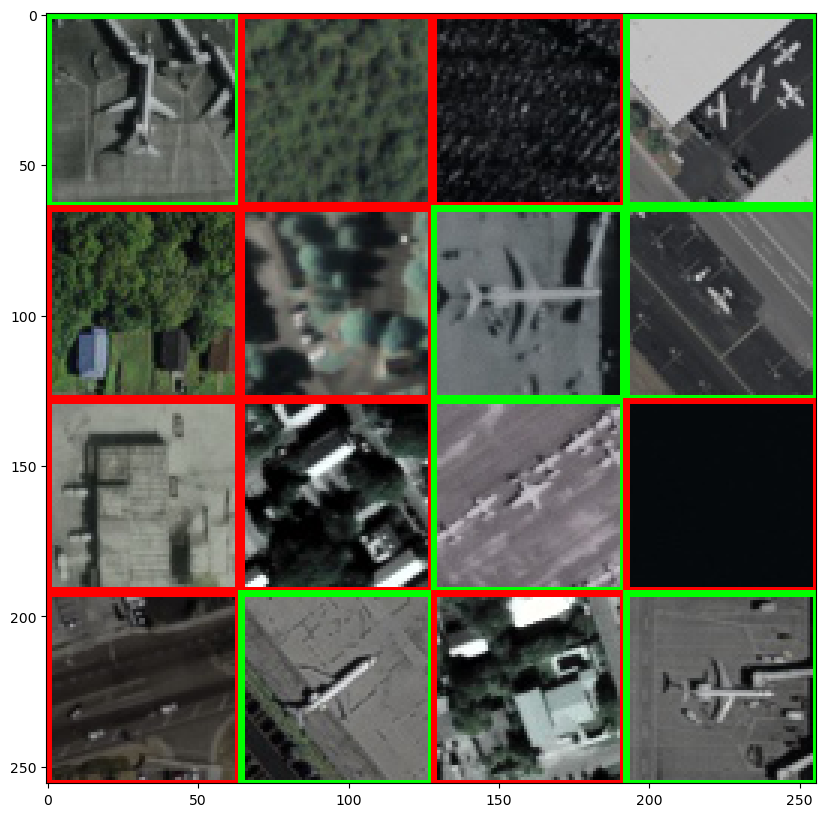

In [116]:
grid_size = 4
grid = np.zeros((grid_size * 64, grid_size * 64, 3)).astype(np.uint8)
for i in range(grid_size):
    for j in range(grid_size):
        tile = np.copy(trainval_images[i * grid_size + j])
        label = np.copy(trainval_labels[i * grid_size + j])
        color = (0, 255, 0) if label == 1 else (255, 0, 0)
        tile = cv2.rectangle(tile, (0, 0), (64, 64), color, thickness=2)
        grid[i * 64 : (i + 1) * 64, j * 64 : (j + 1) * 64, :] = tile

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(grid)
plt.show()

In [117]:
X = np.array([trainval_images[i] for i in [0,3,6,7,11,13]])
Y = np.array([trainval_labels[i] for i in [0,3,6,7,11,13]])
X.shape


(6, 64, 64, 3)

In [118]:
keras_model.build(input_shape=(None, 64, 64, 3))
print(keras_model.input)

AttributeError: The layer sequential_10 has never been called and thus has no defined input.

In [99]:
explainer = Lime(keras_model)
explanations = explainer(X, Y)

for i in range(len(X)):
  plt.subplot(1, len(X), i+1)
  plt.imshow(X[i]/255.0)
  plt.imshow(explanations[i], cmap="jet", alpha=0.5)
  plt.axis('off')

AttributeError: The layer sequential_8 has never been called and thus has no defined input.